<a href="https://colab.research.google.com/github/Sharon972/me/blob/my-works/prediction_cloud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

THE FINAL WORK




In [ ]:
!pip install rasterio
import rasterio
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
#ABRO LA IMAGEN CON LA LIBRERIA RASTERIO

file_path= r"/content/drive/MyDrive/lucydeep/S2_2022.tif"
with rasterio.open(file_path,"r") as src:
    data = src.read()
    transform = src.transform

In [69]:
#RECORTO LA IMAGEN
#recorto mi imagen a una de dimensiones 512x512

data = data[:, 0:512, 0:512]

In [70]:
#GUARDO LA IMAGEN RECORTADA
with rasterio.open('recorte_img.tif', 'w', **src.meta) as dst:
    dst.write(data)

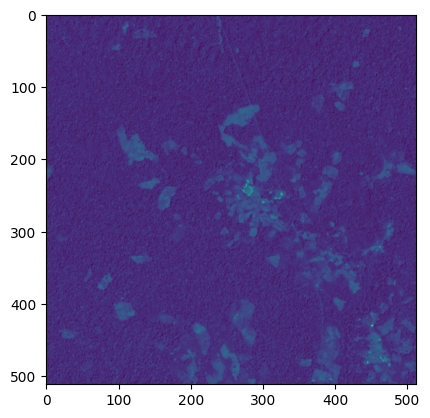

In [84]:
#HAGO UNA PEQUEÑA VISUALIZACIÓN DE CUALQUIER BANDA
with rasterio.open('recorte_img.tif') as src:
    img = src.read(3, masked=True)
    plt.imshow(img)

In [72]:
#le agrego una dimension mas a las bandas ya que en la descarga solo hay 12 asi que es necesario agregarle una mas, la que falta es la banda 10, asi que le agrego una
band_10 = np.zeros((512,512))
resamp_data13 = np.concatenate([np.expand_dims(band_10, axis=0), data], axis=0)
resamp_data13.shape

(13, 512, 512)

In [73]:
#LE AGREGO EL BATCH

batch_data = np.expand_dims(resamp_data13, axis=0)
batch_data.shape

(1, 13, 512, 512)

In [93]:
#CONVIERTO A TORCH
import torch

imagen = torch.from_numpy(batch_data).type(torch.float)
imagen.shape

torch.Size([1, 13, 512, 512])

In [94]:
#A resamp_data tambien lo convierto en torch

recorte_torch = torch.from_numpy(resamp_data13).type(torch.float)
recorte_torch.shape

torch.Size([13, 512, 512])

In [ ]:
#PRUEBO EL MODELO

!pip install segmentation_models_pytorch
!pip install torchinfo


In [12]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="mobilenet_v2",
    encoder_weights="imagenet",
    in_channels=13,
    classes=4
)
model = model.cuda()

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 98.8MB/s]


In [ ]:
#CARGO EL MODELO CON LOS PARÁMETROS PARA CLASIFICAR NUBES
model.load_state_dict(torch.load('/content/drive/MyDrive/lucydeep/model.pt'))

model.eval()

In [77]:
#HAGO LA PREDICCIÓN
preds = model.predict(imagen)

In [78]:
#PASO LA PREDICCIÓN DE TORCH A NUMPY
preds_cpu = preds.cpu()
preds_np=preds_cpu.numpy()

In [79]:
#USO EL ARGMAX
tensor = np.squeeze(preds_np)
tensor.shape

(4, 512, 512)

In [80]:
indice_max = np.argmax(tensor, axis=0)
indice_max.shape

(512, 512)

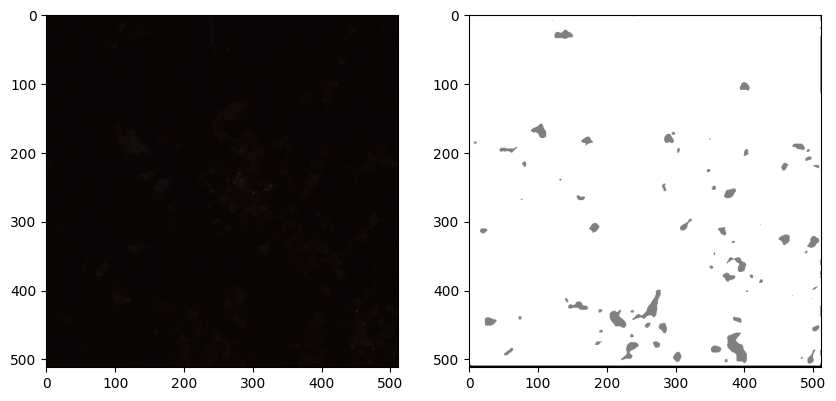

In [95]:
#VIZ
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(torch.moveaxis(recorte_torch[[3, 2, 1]], 0, 2))
ax[1].imshow(indice_max, cmap="gray")